In [8]:
import numpy as np
import pdb
import math
from numpy import linalg as LA
from scipy import spatial
from scipy import special
import sys
np.set_printoptions(threshold=np.inf)
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

from utils.utils import scatter_3D, scatter_2D
import time

from modules.Decomposer import SphericalHarmonicsDecomposer
from modules.Form import Form3D, Form2D
from modules.Loader import TXTFormLoader, RAWFormLoader


from scipy.spatial.distance import cdist
from scipy import ndimage, misc
from scipy.signal import resample_poly
import scipy.interpolate as SP

import os
import argparse
import yaml
import shutil

from utils.utils import voxels_view_3D, voxels_view_2D

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

%load_ext autoreload

%autoreload 2


In [17]:

OBJ_PATH    = 'data/3DSyntheticForm/raw/defect10.raw'
OBJ_PATH    = 'data/3DSyntheticForm/txt/losange.txt'
OBJ_PATH    = 'data/3DSyntheticForm/txt/star.txt'
CONFIG_PATH = 'config/3Dconfig.yaml'
SAVE_PATH   = 'decompositions/3D/default'
SAVE_NAME   = 'mic'
FIG_PATH    = os.path.join(SAVE_PATH,'plots')
PLOT        = False
VERB        = False
FORCE       = False
TEST_BOOL   = False

print(f"\n----- LOAD PATH -----")
print(f"3D Object path (load) : {OBJ_PATH}")
print(f"Process configuration path (load)  : {CONFIG_PATH}")

print(f"\n----- SAVE PATH -----")
print(f"Decompositions path (save) : {SAVE_PATH}")
print(f"Decompositions name (file) : {SAVE_NAME}")

try:
  os.makedirs(SAVE_PATH)
  os.makedirs(FIG_PATH)
except FileExistsError:
  if not FORCE : 
    #answer = input("WARNING : The save path already exists, do you want to use it ? (y/n)\n")
    answer='y'
    if answer == 'y':
      os.makedirs(SAVE_PATH,exist_ok=True)
      os.makedirs(FIG_PATH,exist_ok=True)
    else:
      print("Exiting")
      exit()
  else:
      os.makedirs(SAVE_PATH,exist_ok=True)
      os.makedirs(FIG_PATH,exist_ok=True)


###### LOAD FORM ######
    
loader_selector = {
'raw' : RAWFormLoader,
'txt' : TXTFormLoader
}

file_type = OBJ_PATH.split('.')[-1]

if file_type not in loader_selector.keys(): 
    print("WARNING : File type is not implemented (.raw or .txt)")
    print("Exiting")
    exit()

ratio = 1.2
loader = loader_selector.get(file_type)(OBJ_PATH)
form, scales   = loader.load_form(ratio=ratio)

DIM   = loader.dim
if DIM == 2: 
    OBJECT = Form2D(form, scales)
if DIM == 3: 
    OBJECT = Form3D(form, scales)

print(f"\n----- 3D Object caracteristics -----")
print(f"  * Number of voxels : {OBJECT.n_voxel}")
print(f"  * Cube shape (L) : {OBJECT.shape}")
print(f"  * Barycenter : {OBJECT.barycenter}")
print(f"  * Size boundary : {OBJECT.size_b}")



# Reading configuration of the process
with open(CONFIG_PATH, "r") as f:
    config = yaml.load(f, Loader=yaml.Loader)
# Copy of the config in checkpoint
shutil.copy2(CONFIG_PATH, SAVE_PATH)
Lmax             = config["parameters"]["Lmax"]
p_points         = config["parameters"]["ratio_points"]
points_selection = config["parameters"]["selection"]

if points_selection == "surface":
  if (Lmax + 1)**2 >= OBJECT.size_b:
    Lmax = int(np.sqrt(OBJECT.size_b) - 1)
    config["parameters"]["Lmax"] = Lmax

# Only useful for sphere and rand_surface points selection
nphi   = int( np.sqrt(OBJECT.size_b * p_points) )
ntheta = nphi
nuni   = nphi * ntheta
config["parameters"]["nphi"]   = nphi
config["parameters"]["ntheta"] = ntheta
config["form"]["L"]            = OBJECT.shape

with open(os.path.join(SAVE_PATH,"3Dconfig.yaml"), "w") as f:
  yaml.dump(config, f)
   
print(f"\n----- Process Configuration -----")
print(f"  * Mode : {Lmax}")
print(f"  * Points selection : {points_selection}")
if points_selection in ['sphere','rand_surface']:
  print(f"  * Points ratio : {round(p_points * 100., 2)}%")
  print(f"  * Number of angle (polar)  : {ntheta}")
  print(f"  * Number of angle (azimuthal)  : {nphi}")


############################ PROCESS 3D OBJECT #######################################

form = OBJECT.get_array_form()
form_boundaries = OBJECT.get_array_boundaries()

# ************** Compute Spherical Decomposition ************** #

SHD = SphericalHarmonicsDecomposer(OBJECT, TEST_BOOL)
SHD.fit(Lmax=Lmax,nphi=nphi,ntheta=ntheta,points_selection=points_selection)

if PLOT and DIM == 2:
  scatter_2D(os.path.join(FIG_PATH,'original'),'original','Original',[form[0],SHD.bx], [form[1],SHD.by])
  scatter_2D(os.path.join(FIG_PATH,'boundary'),'boundary','Boundaries',[SHD.bx], [SHD.by])
  scatter_2D(os.path.join(FIG_PATH,'boundary_sphere'),'boundary_sphere','Boundaries Spherical Coordinates',[SHD.bsx], [SHD.bsy])
  scatter_2D(os.path.join(FIG_PATH,'boundary_selected'),'boundary_selected','Selected Boundaries',[SHD.xi], [SHD.yi])

if PLOT and DIM == 3:
  selected_points = np.random.randint(0,len(SHD.bx),1000)
  scatter_3D(os.path.join(FIG_PATH,'original'),'original','Original',form[0], form[1], form[2])
  scatter_3D(os.path.join(FIG_PATH,'boundary'),'boundary','Boundaries',SHD.bx[selected_points], SHD.by[selected_points], SHD.bz[selected_points])
  scatter_3D(os.path.join(FIG_PATH,'boundary_sphere'),'boundary_sphere','Boundaries Spherical Coordinates',SHD.bsx[selected_points], SHD.bsy[selected_points], SHD.bsz[selected_points])
  scatter_3D(os.path.join(FIG_PATH,'boundary_selected'),'boundary_selected','Selected Boundaries',SHD.xi[selected_points], SHD.yi[selected_points], SHD.zi[selected_points])
if VERB: plt.show()

SHD.compute_full_reconstruction()
if DIM == 2 : CC = np.vstack( (SHD.cx, SHD.cy) )
if DIM == 3 : CC = np.vstack( (SHD.cx, SHD.cy, SHD.cz) )


mic   = OBJECT.form
rmic  = SHD.selected_points_reconstruction
rrmic = SHD.form_reconstruction

error=np.sum(abs(rrmic.ravel()-mic.ravel())) / float(np.sum(mic.ravel()))
print("\n\nerror = "+str(error*100.)+"%\n\n")
np.save(os.path.join(SAVE_PATH,'error'),error)

np.save(os.path.join(SAVE_PATH, 'CC'            ), CC)
np.save(os.path.join(SAVE_PATH,        SAVE_NAME), mic)
np.save(os.path.join(SAVE_PATH, 'r'  + SAVE_NAME), rmic)
np.save(os.path.join(SAVE_PATH, 'rr' + SAVE_NAME), rrmic)

LOAD_PATH = 'decompositions/3D/default'
LOAD_NAME = 'mic'
SAVE_PATH = 'reconstructions/3D/default'
SAVE      = False
VERB      = False
FORCE     = False

print(f"\n----- LOAD PATH -----")
print(f"3D Decompositions path (load) : {LOAD_PATH}")
print(f"\n----- SAVE PATH -----")
print(f"Save (bool) : {SAVE}")
print(f"Figures path (save) : {SAVE_PATH}")



try:
    os.makedirs(SAVE_PATH)
except FileExistsError:
    if not FORCE:
        #answer = input("WARNING : The save path already exists, do you want to use it ? (y/n)\n")
        answer='y'
        if answer == 'y': os.makedirs(SAVE_PATH,exist_ok=True)
        else:
          print("Exiting")
          exit()
    else:
        os.makedirs(SAVE_PATH,exist_ok=True)
        
try:
    CONFIG_PATH = os.path.join(LOAD_PATH,'3Dconfig.yaml')
    # Reading configuration of the process
    with open(CONFIG_PATH, "r") as f:
      config = yaml.load(f, Loader=yaml.Loader)

except FileNotFoundError:
    CONFIG_PATH = os.path.join(LOAD_PATH,'2Dconfig.yaml')
    # Reading configuration of the process
    with open(CONFIG_PATH, "r") as f:
      config = yaml.load(f, Loader=yaml.Loader)

# Copy of the config in checkpoint
shutil.copy2(CONFIG_PATH, SAVE_PATH)

Lmax             = config["parameters"]["Lmax"]
p_points         = config["parameters"]["ratio_points"]
points_selection = config["parameters"]["selection"]
L                = config["form"]["L"]

DIM = len(L)

print(f"\n----- Process Configuration -----")
print(f"  * Mode : {Lmax}")
print(f"  * Points selection : {points_selection}")
print(f"  * Points ratio : {round(p_points * 100., 2)}%")





----- LOAD PATH -----
3D Object path (load) : data/3DSyntheticForm/txt/star.txt
Process configuration path (load)  : config/3Dconfig.yaml

----- SAVE PATH -----
Decompositions path (save) : decompositions/3D/default
Decompositions name (file) : mic

----- 3D Object caracteristics -----
  * Number of voxels : 10580.0
  * Cube shape (L) : (46, 46, 46)
  * Barycenter : [22, 23, 23]
  * Size boundary : 4750

----- Process Configuration -----
  * Mode : 18
  * Points selection : surface
1.0


error = 1.2003780718336485%



----- LOAD PATH -----
3D Decompositions path (load) : decompositions/3D/default

----- SAVE PATH -----
Save (bool) : False
Figures path (save) : reconstructions/3D/default

----- Process Configuration -----
  * Mode : 18
  * Points selection : surface
  * Points ratio : 10.0%


"\nl     = np.max(L)\nmic   = np.load( os.path.join(LOAD_PATH,       LOAD_NAME + '.npy') )\nrmic  = np.load( os.path.join(LOAD_PATH,'r'  + LOAD_NAME + '.npy') )\nrrmic = np.load( os.path.join(LOAD_PATH,'rr' + LOAD_NAME + '.npy') )\nmic   = mic.astype(bool)\nrmic  = rmic.astype(bool)\nrrmic = rrmic.astype(bool)\n\nif DIM == 3:\n    voxels_view_3D(mic   , 0, l, SAVE_PATH)\n    voxels_view_3D(rmic  , 1, l, SAVE_PATH)\n    voxels_view_3D(rrmic , 2, l, SAVE_PATH)\n\nif DIM == 2:\n    voxels_view_2D(mic   , 0, l, SAVE_PATH)\n    voxels_view_2D(rmic  , 1, l, SAVE_PATH)\n    voxels_view_2D(rrmic , 2, l, SAVE_PATH)\n\nif VERB: plt.show()\n"

<IPython.core.display.Javascript object>


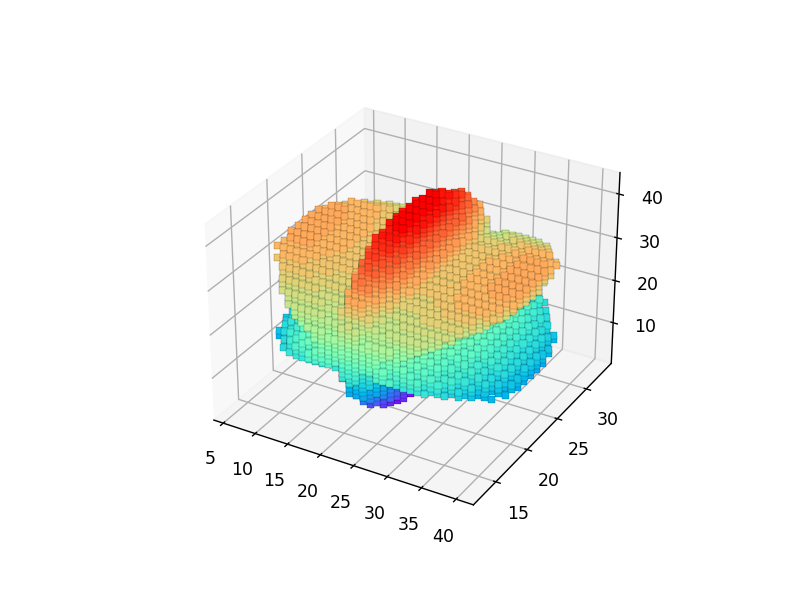

<IPython.core.display.Javascript object>


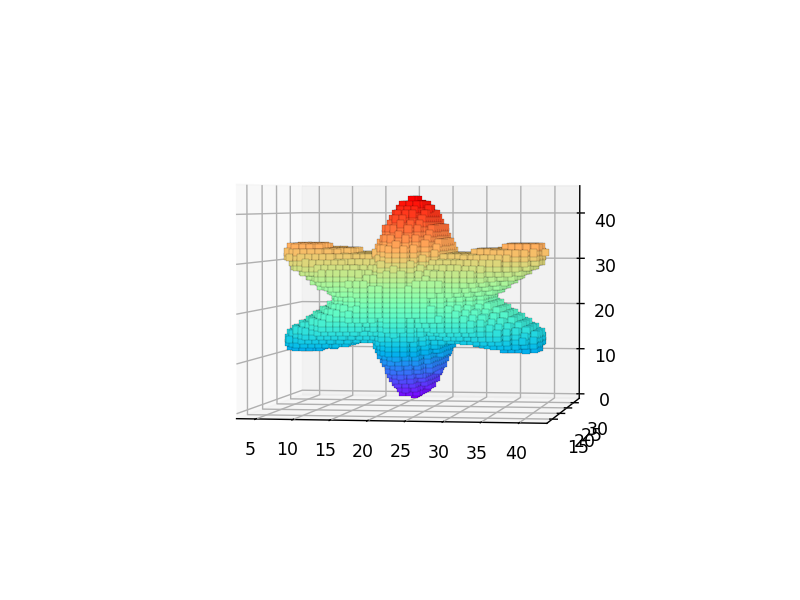

In [18]:
"""
obj=[]
with open(OBJ_PATH, "r") as tf:
    lines = tf.read().split('\n')
    
for line in lines:
    obj.append([int(x) for x in line.split(', ')])
obj=np.array(obj)

X=obj[:,0]
Y=obj[:,1]
Z=obj[:,2]

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z,c=Z,marker="s",s=17,alpha=1,cmap="rainbow",edgecolor='black', linewidth=0.1)


plt.show()

"""

t=mic
tt=rrmic

X=[]
Y=[]
Z=[]

XX=[]
YY=[]
ZZ=[]

kk=int(len(t)/2)

for i in range (len(t)):
    for j in range (len(t)):
        for k in range (len(t)):
            if t[i,j,k]==True:
                X.append(i)
                Y.append(j)
                Z.append(k)

for i in range (len(tt)):
    for j in range (len(tt)):
        for k in range (len(tt)):
            if tt[i,j,k]==True:
                XX.append(i)
                YY.append(j)
                ZZ.append(k)


fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z,c=Z,marker="s",s=17,alpha=1,cmap="rainbow",edgecolor='black', linewidth=0.1)

plt.show()

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(XX,YY,ZZ,c=ZZ,marker="s",s=17,alpha=1,cmap="rainbow",edgecolor='black', linewidth=0.1)

plt.show()



In [22]:
print(SHD.xi[1], SHD.yi[1], SHD.zi[1], SHD.phi[1], SHD.theta[1], SHD.ri[1])

-2.0 -17.5 -10.0 -3.027800646446085 2.0871520805116264 20.254629100529094


In [16]:
print(np.real(SHD.Y.dot(SHD.cr))[:100])
print(SHD.ri[:100])


[19.27378228 20.1085435  19.47297153 19.05877417 19.73335008 20.42394023
 20.39781942 19.76157948 19.34451197 20.05562243 20.12180904 20.60661287
 20.58347564 19.93465384 18.70763509 18.27214955 19.51005363 20.23256442
 20.29271639 20.72042666 20.68339795 20.01832831 18.77498611 18.35767139
 19.57586228 20.27796807 20.32375299 20.7613406  20.70152738 20.02647823
 18.7893993  18.40241768 19.56128704 20.21852852 20.24589433 20.71055194
 20.6255174  19.95204061 19.47285642 20.07852914 20.09273871 20.43621622
 19.77461879 19.30290678 19.86786043 20.12275126 19.16958118 18.77609884
 18.31933499 19.73436377 19.38128571 18.42297301 17.99424732 18.922856
 19.8729656  18.88435655 17.41814146 17.03412537 18.40479268 19.50189105
 19.19147585 17.67972684 17.22240136 18.68117799 17.813692   17.34163124
 17.87387235 17.44034505 17.89613321 17.52279131 19.36760077 17.87181632
 17.54677518 18.87743807 20.28842547 19.17769998 17.75978429 17.45860808
 18.71415749 19.58087732 19.77455138 18.85685034 18.4